In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
import random
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
def split_by_time(data: pd.DataFrame) -> dict:
    # Split the data into time steps
    time_steps = data["t"].unique()
    data_by_time = {t: data[data["t"] == t].drop(columns=["t"]).to_numpy() for t in time_steps}

    return data_by_time

def compute_A_matrix(data: np.ndarray) -> np.ndarray:
    n = data.shape[0]
    # Inner product: each summation term is 1 if both values are 1, 0 otherwise
    return np.dot(data.T, data) / n

def graph_covariance(A: np.ndarray) -> np.ndarray:
    # Computing the diagonal of A is sufficient
    A_diag = np.diag(A)

    return A - np.outer(A_diag, A_diag)

In [3]:
def replace_with_nan(df, column_name, percentage):
    """
    Randomly replaces a specified percentage of values in a DataFrame column with NaN.

    Args:
        df (pd.DataFrame): The DataFrame.
        column_name (str): The name of the column to modify.
        percentage (float): The percentage of values to replace with NaN (0.0 to 1.0).

    Returns:
        pd.DataFrame: The modified DataFrame.
    """
    if not 0 <= percentage <= 1:
        raise ValueError("Percentage must be between 0 and 1")

    series = df[column_name].copy()
    num_to_replace = int(len(series) * percentage)
    random_indices = np.random.choice(series.index, num_to_replace, replace=False)
    series[random_indices] = np.nan
    df[column_name] = series
    return df


In [4]:
def median_impute(df):
    column_names = list(df.columns)

    for col in column_names:
        med = df[col].median()
        df[col] = df[col].fillna(med)
    return df

In [5]:
def mode_impute(df):
    column_names = list(df.columns)

    for col in column_names:
        mode = df[col].mode(dropna=True)[0]
        df[col] = df[col].fillna(mode)

    return df

In [6]:
def locf_impute(df):
    for j in range(df.shape[1]):
        for i in range(df.shape[0]):
            # Assign median if in the first point in column
            if pd.isna(df.iloc[i,j]):
                if i == 0:
                    med = df.iloc[:,j].median()
                    df.iloc[i,j] = med
                elif i != 0 and not pd.isna(df.iloc[i-1,j]):
                    df.iloc[i,j] = df.iloc[i-1,j]

    return df

In [7]:
def lin_reg_impute(df, X, y: str):
    # Separate data into complete and incomplete cases
    complete_cases = df.dropna()
    missing_cases = df[df.isnull().any(axis=1)]

    # Fit the regression model on complete cases
    X_complete = complete_cases[X]
    y_complete = complete_cases[y]
    model = LinearRegression().fit(X_complete, y_complete)

    # Impute the missing values with mean
    imputer = SimpleImputer(strategy='median')
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    # Creata a DataFrame with imputed values
    # df_imputed = pd.DataFrame(X_imputed, columns=X)
    # df_imputed[y] = df[y]

    print(df_imputed)
    return df_imputed

In [8]:
def stochastic_reg_impute(df):
    df_imputed = df.copy()
    
    for column in df.columns:
        missing_mask = df[column].isnull()
        if missing_mask.sum() == 0:
            continue  # Skip if no missing values
        
        # Define features (X) and target (y)
        X_train = df.loc[~missing_mask].drop(columns=[column])
        y_train = df.loc[~missing_mask, column]
        X_test = df.loc[missing_mask].drop(columns=[column])
        
        # Use mean imputation for missing values in predictors
        imputer = SimpleImputer(strategy='median')
        X_train_imputed = imputer.fit_transform(X_train)
        X_test_imputed = imputer.transform(X_test)
        
        # Train a regression model
        model = LinearRegression()
        model.fit(X_train_imputed, y_train)
        
        # Predict missing values
        y_pred = model.predict(X_test_imputed)
        
        # Add stochastic noise based on training residuals
        residual_std = np.std(y_train - model.predict(X_train_imputed))
        noise = np.random.normal(0, residual_std, size=len(y_pred))
        y_pred_stochastic = y_pred + noise
        
        # Fill missing values with stochastic predictions
        df_imputed.loc[missing_mask, column] = y_pred_stochastic
    
    return df_imputed

In [9]:
def mice_impute(df):
    # Create kernels for MICE forest imputation
    kernel = mf.ImputationKernel(
      data=df,
      save_all_iterations=True,
      random_state=1343
    )
    # Run the MICE algorithm for 3 iterations on each of the datasets
    kernel.mice(3,verbose=True)
    completed_dataset = kernel.complete_data(dataset=0, inplace=False)
    return completed_dataset

In [30]:
def miss_forest_impute(df):
    imputer = MissForest()
    X_imputed = imputer.fit_transform(df)
    X_imputed = pd.DataFrame(X_imputed, columns = df.columns)

    return X_imputed

In [16]:
def knn_impute(df):
    # Create and fit the KNNImputer
    imputer = KNNImputer(n_neighbors=4)
    imputed_data = imputer.fit_transform(df)   
    df_kNN_imputed = pd.DataFrame(imputed_data, columns=df.columns)
    return df_kNN_imputed

In [31]:
# Load data
data = pd.read_csv("simple_gen_data.csv")
data

,t,X1,X2,X3,X4,X5,X6,X7
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
39995,8,0,1,0,0,0,0,0
39996,8,1,0,1,1,0,1,1
39997,8,0,0,0,0,0,0,0
39998,8,0,0,0,0,0,0,0


In [32]:
# Replace random elements with NaN based on CTDC percentages, then use median imputation to impute the 'missing' data
data_copy = data.drop('t', axis=1)

# Drop percentages based on percent Nan from first 7 columns of CTDC 2024 dataset
percent_to_drop = np.array([
    0.20145084842363767,
    0.4748657902346418,
    0.5116021775298698,
    0.21924490505785374,
    0.9072202967911189,
    0.8529119642610186,
    0.8260993466572234
])

i = 0
for col in list(data_copy.columns):
    data_copy = replace_with_nan(data_copy, col, percent_to_drop[i])
    i += 1

# Now, use imputation to impute the 'missing' data
data_copy = miss_forest_impute(data_copy)
data_copy.insert(0, 't', data['t'])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3


In [33]:
data = split_by_time(data)
data_copy = split_by_time(data_copy)

# Get adjacency for each timestep
adj_matrices = {t: compute_A_matrix(data[t]) for t in data}
adj_matrices_med_imp = {t: compute_A_matrix(data_copy[t]) for t in data_copy}

# Get graph covariances for each timestep
graph_cov = {t: graph_covariance(adj_matrices[t]) for t in adj_matrices}
graph_cov_med_imp = {t: graph_covariance(adj_matrices_med_imp[t]) for t in adj_matrices_med_imp}

graph_covariances_over_time = np.array([graph_cov[t][0, :] for t in sorted(list(graph_cov.keys()))])[:, 1:]
graph_covariances_over_time_med_imp = np.array([graph_cov_med_imp[t][0, :] for t in sorted(list(graph_cov_med_imp.keys()))])[:, 1:]

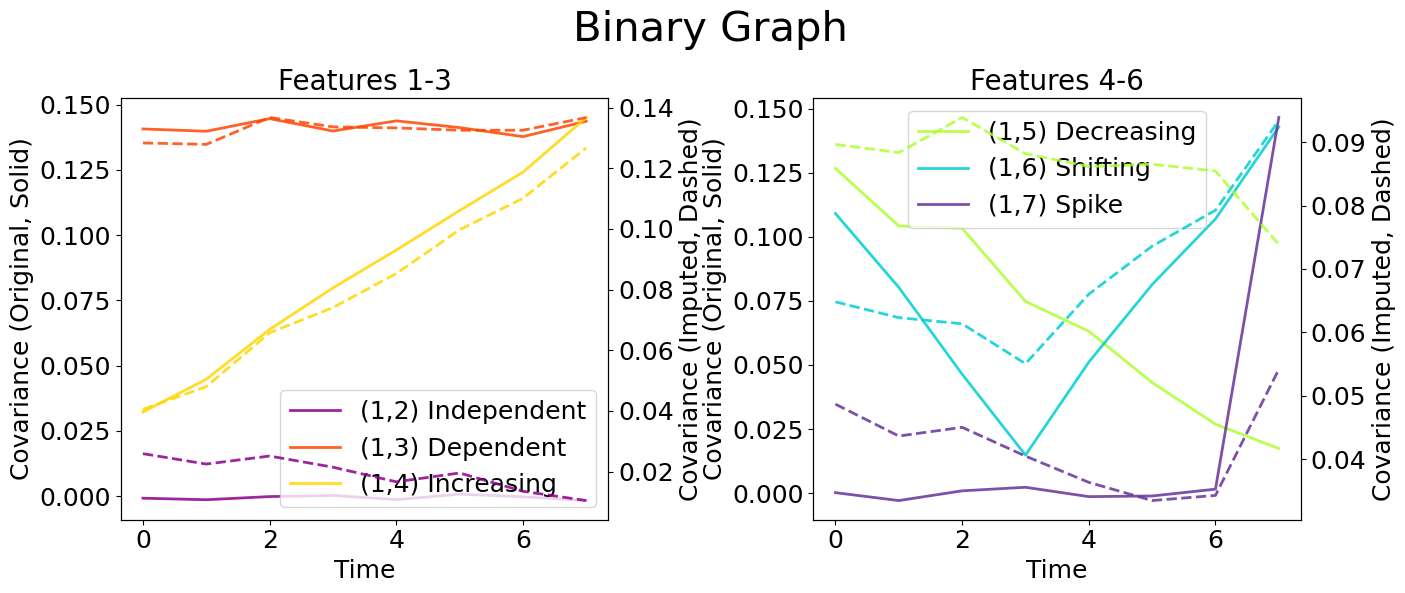

In [34]:
# Time to plot!

legend_labels = [
    "(1,2) Independent", 
    "(1,3) Dependent", 
    "(1,4) Increasing", 
    "(1,5) Decreasing", 
    "(1,6) Shifting", 
    "(1,7) Spike"
]

colors = [
    "darkmagenta",
    "orangered",
    "gold",
    "greenyellow",
    "darkturquoise",
    "rebeccapurple"
]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)
ax1_alt = ax1.twinx()
ax2_alt = ax2.twinx()

# Define increased font sizes
title_fontsize = 20
label_fontsize = 18
legend_fontsize = 18
tick_fontsize = 18

# Plot the first 3 features in the left subplot
for i in range(3):
    ax1.plot(graph_covariances_over_time[:, i],
            label=legend_labels[i],
            linewidth=2,
            color=colors[i],
            alpha=0.85)
    ax1_alt.plot(graph_covariances_over_time_med_imp[:, i],
            '--',
            label=legend_labels[i] + " (Imputed)",
            linewidth=2,
            color=colors[i],
            alpha=0.85)
ax1.set_title("Features 1-3", fontsize=title_fontsize)
ax1.set_xlabel("Time", fontsize=label_fontsize)
ax1.set_ylabel("Covariance (Original, Solid)", fontsize=label_fontsize)
ax1.legend(loc="lower right", fontsize=legend_fontsize)
ax1.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax1.grid(True)

ax1_alt.set_ylabel("Covariance (Imputed, Dashed)", fontsize=label_fontsize)
# ax1_alt.legend(loc="best", fontsize=legend_fontsize)
ax1_alt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax1_alt.grid(True)

# Plot the last 3 features in the right subplot
for i in range(3, 6):
    ax2.plot(graph_covariances_over_time[:, i],
            label=legend_labels[i],
            linewidth=2,
            color=colors[i],
            alpha=0.85)
    ax2_alt.plot(graph_covariances_over_time_med_imp[:, i],
            '--',
            label=legend_labels[i] + " (Imputed)",
            linewidth=2,
            color=colors[i],
            alpha=0.85)
ax2.set_title("Features 4-6", fontsize=title_fontsize)
ax2.set_xlabel("Time", fontsize=label_fontsize)
ax2.set_ylabel("Covariance (Original, Solid)", fontsize=label_fontsize)
ax2.legend(loc="best", fontsize=legend_fontsize)
ax2.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax2.grid(True)

ax2_alt.set_ylabel("Covariance (Imputed, Dashed)", fontsize=label_fontsize)
# ax2_alt.legend(loc="best", fontsize=legend_fontsize)
ax2_alt.tick_params(axis='both', which='major', labelsize=tick_fontsize)
# ax2_alt.grid(True)

fig.suptitle("Binary Graph", fontsize=title_fontsize*1.5)
# ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
